In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
import sys
sys.path.append("../..")

In [6]:
from rom_tools.rom_manager import RomManager
from world_rando.parse_rules import parse_rules, make_level_from_room
from world_rando.coord import Coord

In [8]:
manager = RomManager("../../../roms/sm_clean.smc", "../../../roms/sm_junk.smc")
obj_names = manager.parse() # slow

In [9]:
header = obj_names["room_header_0x7a107"]
level = make_level_from_room(header)

In [10]:
from world_rando.parse_rules import parse_rules, make_level_from_room

In [11]:
rule_level = make_level_from_room(header)

In [12]:
from world_rando.rules import AbstractTile

In [35]:
# Edit to add unknowns
rule_level.level.flags.writeable = True
for y in range(4,10):
    rule_level.level[6,y] = AbstractTile.UNKNOWN

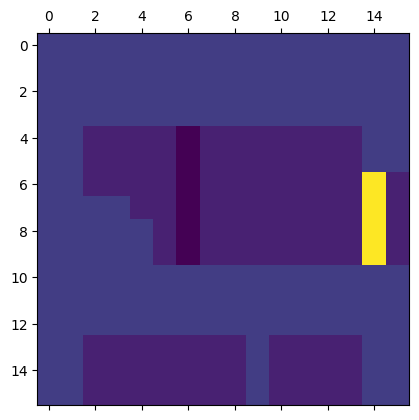

In [36]:
matshow(rule_level.level.T)

In [15]:
from bdds.bdd_core import *

In [16]:
context = mk_context()

In [17]:
# Add variables to the context
new_vs = {}
for y in range(4,9):
    new_vs[f"is_solid_6_{y}"] = (0,1)
context.declare(**new_vs)

In [18]:
solids = list(new_vs.keys())

In [19]:
dc_trans = mk_trans(header, context, rule_level)

100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [00:07<00:00, 32.50it/s]


In [20]:
dc_trans.count()

7533029039800320.0

In [21]:
dc_trans.dag_size

1300

In [22]:
norule_dc_trans = context.exist(["rule"], dc_trans)

In [23]:
all_reachable_dc = mk_closure(norule_dc_trans, context)

0 2377
1 5657
2 17773
3 20796
4 11445
5 11207
6 11207


In [24]:
# Restrict to a single starting point
reachable_dc = all_reachable_dc & context.add_expr("x_prev = 13 & M_prev = 0 & pose_prev = 0")

In [25]:
# Have missiles with no morph ball
goal_womorph_n = context.exist(prevs, reachable_dc & context.add_expr("M_next = 1 & MB_next = 0"))

In [26]:
# Have missiles with any other conditions
goal_any_n = context.exist(prevs, reachable_dc & context.add_expr("M_next = 1"))

In [27]:
context.pick(goal_any_n & ~goal_womorph_n)

{'room_id_next': 41223,
 'x_next': 8,
 'y_next': 9,
 'pose_next': 1,
 'vt_next': 1,
 'vh_next': 0,
 'vv_next': 0,
 'B_next': 0,
 'M_next': 1,
 'MB_next': 1,
 'is_solid_6_4': 0,
 'is_solid_6_5': 0,
 'is_solid_6_6': 0,
 'is_solid_6_7': 0,
 'is_solid_6_8': 0}

In [28]:
sanity = context.add_expr("MB_prev = 0 & MB_next = 1") & reachable_dc

In [29]:
sanity.count()

0.0

In [30]:
no_goal_womorph_n = context.forall(nexts, ~goal_womorph_n)

In [31]:
check = ~context.exist(nexts, goal_womorph_n)

In [32]:
check == no_goal_womorph_n

True

In [33]:
no_goal_womorph_n.count()

21.0

In [34]:
# Proposes a nicely minimal set of tiles to change to solid in order to prevent picking up the missiles without morph
context.pick(no_goal_womorph_n & goal_any_n)

{'room_id_next': 41223,
 'x_next': 8,
 'y_next': 9,
 'pose_next': 1,
 'vt_next': 1,
 'vh_next': 0,
 'vv_next': 0,
 'B_next': 0,
 'M_next': 1,
 'MB_next': 1,
 'is_solid_6_4': 1,
 'is_solid_6_5': 0,
 'is_solid_6_6': 0,
 'is_solid_6_7': 0,
 'is_solid_6_8': 1}

In [36]:
#all_solid = context.assign_from({k:1 for k in solids})

In [37]:
#(all_solid & goal_womorph_n).count()

In [38]:
# Okay, now let's go even further

In [ ]:
rule_level2 = make_level_from_room(header)

In [ ]:
# Edit to add unknowns
rule_level2.level.flags.writeable = True
for x in range(0, 16):
    for y in range(0, 16):
        rule_level2.level[x,y] = AbstractTile.UNKNOWN
# Add a perimeter box to avoid pesky negatives
#TODO: can use the context to figure out whether an unknown has a corresponding variable?
for x in range(0, 16):
    rule_level2.level[x,0] = AbstractTile.SOLID
    rule_level2.level[0,x] = AbstractTile.SOLID
    rule_level2.level[x,15] = AbstractTile.SOLID
    rule_level2.level[15,x] = AbstractTile.SOLID

In [ ]:
rule_level2.level

In [90]:
context2 = mk_context()

In [91]:
# Add variables to the context
new_vs = {}
for x in range(0,16):
    for y in range(0,16):
        new_vs[f"is_solid_{x}_{y}"] = (0,1)
context.declare(**new_vs)

In [93]:
dc_trans2 = mk_trans(header, context, rule_level2)

100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [01:16<00:00,  3.36it/s]


In [94]:
dc_trans2.count()

4.8903812434739566e+73

In [95]:
dc_trans2.dag_size

738695

In [96]:
norule_trans2_dc = context.exist(["rule"], dc_trans2)

In [ ]:
# Gross - At the moment the first step of this takes ~5 min and produces a BDD with dag size 3413275
# It uses iterative squaring, so I guess it takes O(log_2(length_of_longest_path)). In this case, it probably takes ~12 steps?
# Seems like based on applying this in the past, the BDD size doubles for the first few stages, meaning we might get a ~200,000,000-node bdd?
# Further steps will take longer as well...
#all_reachable2_dc = mk_closure(norule_trans2_dc, context)

0 3413275
